# Plaintext linear regression

In this Jupyter playbook, the plaintext linear regression model is implemented by using the dataset Apartment rental offers in Germany from kaggle (https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany). The code is based on the code from the module Advanced Machine Learning Exercises, made by Solange Emmenegger (Solange Emmenegger, Hochschule Luzern, Module Advanced Machine Learning, accessed on 19 April 2024 at https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/tree/master/notebooks/03A%20Supervised%20Learning, and https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/blob/master/notebooks/04B%20Gradient%20Descent/Gradient%20Descent.ipynb) and modified where necessary. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from collections import defaultdict
import psutil

%matplotlib inline

## Data cleaning

In this section, the dataset is prepared for processing. The following actions are performed:

- Amount of features reduced
- Data converted to appropriate datatypes
- Unsensical data is removed
- NA values are removed
- Outliers are removed as linear regression is sensitive to outliers
- Categorical data is converted to numeric data
- The data is split into a train and test set
- The data is scaled as linear regression is sensitive to data ranges.

The code leans on the exercises from the module ADML (https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/tree/master/notebooks/03A%20Supervised%20Learning).

In [2]:
df = pd.read_csv("immo_data.csv")

columns_to_drop = ['serviceCharge', 'telekomTvOffer', 'noParkSpaces', 'pricetrend','regio3', 'heatingType', 'telekomUploadSpeed', 'telekomHybridUploadSpeed', 'lastRefurbish', 'newlyConst', 'picturecount', 'firingTypes', 'hasKitchen', 'geo_bln','cellar', 'yearConstructedRange', 'baseRent', 'houseNumber', 'geo_krs', 'interiorQual', 'petsAllowed', 'street', 'streetPlain', 'baseRentRange', 'geo_plz', 'thermalChar', 'floor', 'numberOfFloors', 'noRoomsRange', 'garden', 'livingSpaceRange', 'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass', 'electricityBasePrice', 'electricityKwhPrice', 'date' ]
df = df.drop(columns=columns_to_drop, axis=1)
df['regio1'] = df.regio1.astype('category')
df['regio2'] = df.regio1.astype('category')
df['balcony'] = df['balcony'].astype(int)
df['lift'] = df['lift'].astype(int)
df['condition'] = df.condition.astype('category')
df['typeOfFlat'] = df.typeOfFlat.astype('category')
df = df.dropna()
df = df[(df['totalRent'] != 0) & (df['livingSpace'] != 0) & (df['yearConstructed'] > 1940) & (df['yearConstructed'] < 2021)]
numerical_cols = ['totalRent', 'yearConstructed', 'livingSpace', 'noRooms']
# Remove outliers
q3 = df.loc[:, numerical_cols].describe().loc['75%']
iqr = q3 - df.loc[:, numerical_cols].describe().loc['25%']
upper_boundary = q3 + 1.5*iqr
upper_boundary

df = df[(df.totalRent <= upper_boundary.totalRent) &
        (df.yearConstructed <= upper_boundary.yearConstructed) &
        (df.livingSpace <= upper_boundary.livingSpace) &
         (df.noRooms <= upper_boundary.noRooms) ]

df = pd.concat([df, pd.get_dummies(df.regio1)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.regio2)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.condition)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.typeOfFlat)], axis='columns')
df.drop('regio1', axis='columns', inplace=True)
df.drop('regio2', axis='columns', inplace=True)
df.drop('condition', axis='columns', inplace=True)
df.drop('typeOfFlat', axis='columns', inplace=True)
df.drop(['scoutId'], axis='columns', inplace=True)

train_rents, test_rents = train_test_split(df, test_size=0.4, random_state=42, shuffle=True)
scaler = StandardScaler()
train_rents = pd.DataFrame(scaler.fit_transform(train_rents), columns=train_rents.columns, index=train_rents.index)
test_rents = pd.DataFrame(scaler.transform(test_rents), columns=test_rents.columns, index=test_rents.index)
X_train_rents = train_rents.drop(columns=["totalRent"]).values
X_test_rents = test_rents.drop(columns=["totalRent"]).values
y_train_rents = train_rents.totalRent.values
y_test_rents = test_rents.totalRent.values



## Cost function

The following code implements the cost function: $$J = \frac{1}{N} \sum_{j=1}^N (y_j - \hat{y}_j)^2$$

In [3]:
def cost(y, y_pred):
    cost = np.sum(np.square(y - y_pred))/ (2 * len(y))
    return cost

## Predict function

The predict function implements the equation of the linear regression in arbitrary dimensions: $$\check{Y} = \theta X$$


In [4]:
def predict(X, bias, thetas):
    y_pred = bias + np.dot(X, thetas)
    return y_pred

## Gradient function 

The gradient function calculates the gradient at a given theta. According to theory, the equation is the following:

$$dJ(\theta) = -2X^T y + 2X^T X\theta$$

However, the code implements the gradient in a different way, with the same result.

In [5]:
def gradient(X, y, bias, thetas):
    diff = predict(X, bias, thetas) - y
    n = len(X)
    grad_bias = np.sum(diff) / n
    grad_thetas = np.dot(diff, X) / n
    
    return grad_bias, grad_thetas

## Fit function

The fit function optimizes the parameters theta and the bias to the training data. The data is fitted with a mini batch approach, therefore mini batches of samples are fed into the algorithm. As with other code, this code is based on the exercises at the ADML module (https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/blob/master/notebooks/04B%20Gradient%20Descent/Gradient%20Descent.ipynb).

In [6]:
def fit(X_train, y_train, alpha, num_epochs, batch_size, display_every=50):
    bias = 0.0
    thetas = np.random.randn(*(1, X_train.shape[1])).reshape(-1)
    hist = defaultdict(list)
    
    indices_train = np.arange(len(X_train))   
    
    num_samples = len(X_train)
    steps = int(num_samples/batch_size)
    
    for epoch in tqdm(range(1, num_epochs + 1)):
        # randomize inputs
        np.random.shuffle(indices_train)
        
        X_train_epoch = X_train[indices_train]
        y_train_epoch = y_train[indices_train]
        
        # create minibatches and feed them into the algorithm.
        for step in range(steps):
            start = step * batch_size
            end = step * batch_size + batch_size
            
            X_train_mini = X_train_epoch[start:end]
            y_train_mini = y_train_epoch[start:end]
        
            grad_bias, grad_thetas = gradient(X_train_mini, y_train_mini, bias, thetas)
            bias = bias - alpha * grad_bias
            thetas = thetas - alpha * grad_thetas

        y_pred_train = predict(X_train, bias, thetas)
        
        train_cost = cost(y_train, y_pred_train)
        train_r2 = r2_score(y_train, y_pred_train)

        hist["train_cost"].append(train_cost)
        hist["train_r2"].append(train_r2)
        
        if epoch % display_every == 0 or epoch == num_epochs:
            print("Epoch {0} - train_cost: {1:.2} - train_r2: {2:.4}".format(epoch, train_cost, train_r2))
        
    return bias, thetas, hist

In the following cell, the parameters of the training are defined. 

- len_taken is the sliced dataset for comparison. The encrypted linear regression takes significantly more time, therefore, it was decided to cut the dataset to avoid days of training
- batch_size is how many samples are taken at once to train
- alpha defines the size of the step
- num_epochs defines for how many epochs the linear regression will be trained

In [7]:
len_taken = 10000
batch_size = 600

alpha = 0.01
num_epochs = 6

cpu_percent = psutil.cpu_percent()
mem_usage = psutil.Process().memory_info().rss
t_start = time()
bias, thetas, hist_rent = fit(X_train_rents[:len_taken], y_train_rents[:len_taken], alpha, num_epochs, batch_size)
cpu_percent_end = psutil.cpu_percent()
mem_usage_end = psutil.Process().memory_info().rss
t_end = time()
print(f"Training of the plaintext linear regression took {int(t_end - t_start)} seconds")

# Calculate the differences
cpu_diff = cpu_percent_end - cpu_percent
mem_diff = mem_usage_end - mem_usage
t_end = time()
print(f"CPU usage difference: {cpu_diff}%")
print(f"Memory usage difference: {mem_diff} bytes")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 - train_cost: 1.4 - train_r2: -1.749
Training of the plaintext linear regression took 0 seconds
CPU usage difference: 69.2%
Memory usage difference: 86315008 bytes


The following is a helper function from the ADML exercises to visualise the cost and r2 score changing with epochs.

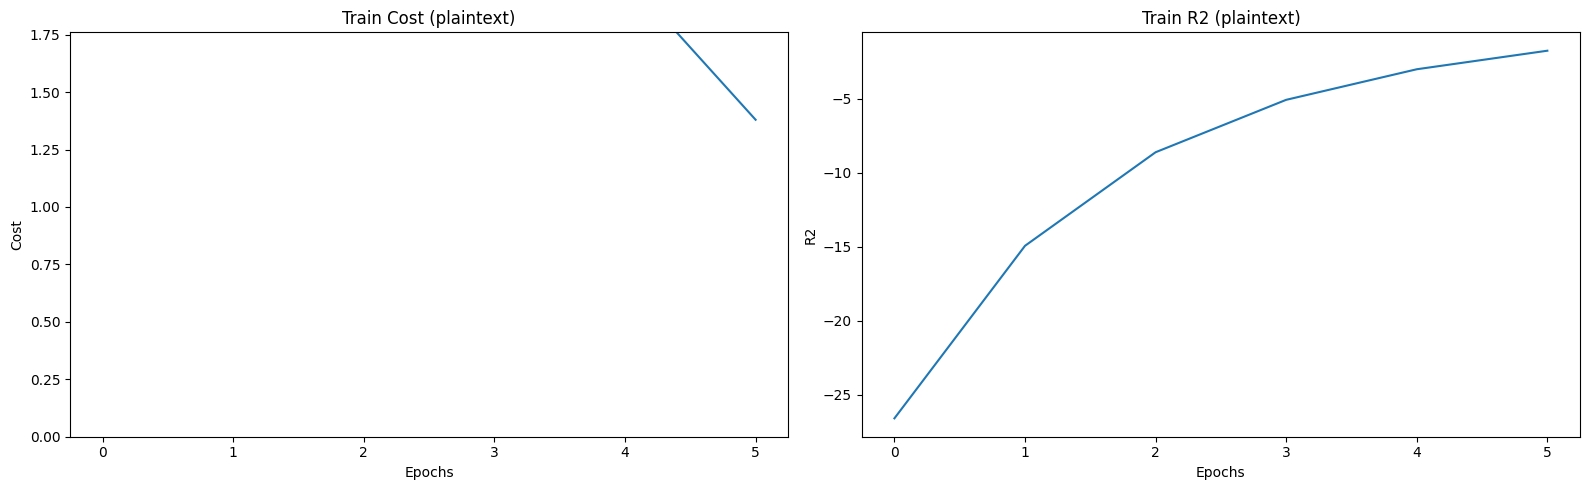

In [8]:
def plot_validation_curve(data, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title("Validation Curve")
        ax.set_ylabel("Cost")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel("Epochs")
    ax.plot(data)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))



def plot_validation_curves(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost (plaintext)")
    ax[0].set_ylabel("Cost")
    ax[0].set_ylim(0, 1.76)  # Set y-axis limits vv
    ax[0].set_yticks(np.arange(0, 1.76, 0.25))  # Set y-axis ticks
    plot_validation_curve(hist["train_cost"], ax[0], ylim)

    ax[1].set_title("Train R2 (plaintext)")
    ax[1].set_ylabel("R2")

    plot_validation_curve(hist["train_r2"], ax[1])

    plt.tight_layout()

plot_validation_curves(hist_rent)

Finally, the plain linear regression is validated on the test set.

In [9]:
y_pred_rents_enc = predict(X_test_rents, bias, thetas)
r2 = r2_score(y_test_rents, y_pred_rents_enc)
print("R2:", r2)

R2: -1.81187315177461
